# Feature Governance - Credit History ("Character")

BayesRisk Project

**Author:** Desmond Momanyi Mariita

**Date:** 2026-01-11

---

## 1. Objectives
This batch focuses on the borrower's past behavior. In credit risk, "Past behavior is the best predictor of future behavior." This is often the most predictive category in the entire model.

The "Character" Variables:

1. mths_since_last_delinq: Months since the borrower last failed to pay. (Crucial, but full of missing values).

2. revol_util: How maxed out are their credit cards?

3. earliest_cr_line: How long have they been in the system? (Credit Age).

4. pub_rec: Public records (Bankruptcies, Tax Liens).

#### 1. Setup & Load
Load the data.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the base file
file_path = '../../data/interim/loans_batch2.pkl'
df = pd.read_pickle(file_path)

# Define Character features
char_cols = [
    'mths_since_last_delinq', 
    'revol_util', 
    'earliest_cr_line', 
    'pub_rec', 
    'open_acc', 
    'total_acc'
]

# Clean revol_util: convert from string percentage to float
df['revol_util'] = pd.to_numeric(df['revol_util'].astype(str).str.rstrip('%'), errors='coerce') / 100

print(f"Analyzing {len(char_cols)} character features...")
display(df[char_cols].head())

Analyzing 6 character features...


,mths_since_last_delinq,revol_util,earliest_cr_line,pub_rec,open_acc,total_acc
0,NaN,0.837,Jan-1985,0.0,3.0,9.0
1,NaN,0.094,Apr-1999,0.0,3.0,4.0
2,NaN,0.985,Nov-2001,0.0,2.0,10.0
3,35.0,0.210,Feb-1996,0.0,10.0,37.0
4,38.0,0.539,Jan-1996,0.0,15.0,38.0


#### 2. The "Informative Missingness" of Delinquency
Concept: mths_since_last_delinq has roughly 50% missing values.

- Standard Data Science: "Drop columns with 50% missing." -> WRONG.

- Credit Risk: Missing means "Never Delinquent." This is the best possible signal.

We must visualize this to prove that "Missing" is a low-risk group compared to "Recent Delinquency."
What to expect: We should see a steep downward slope. Borrowers delinquent in the last 12 months are very risky. "Never Delinquent" borrowers should be among the safest.

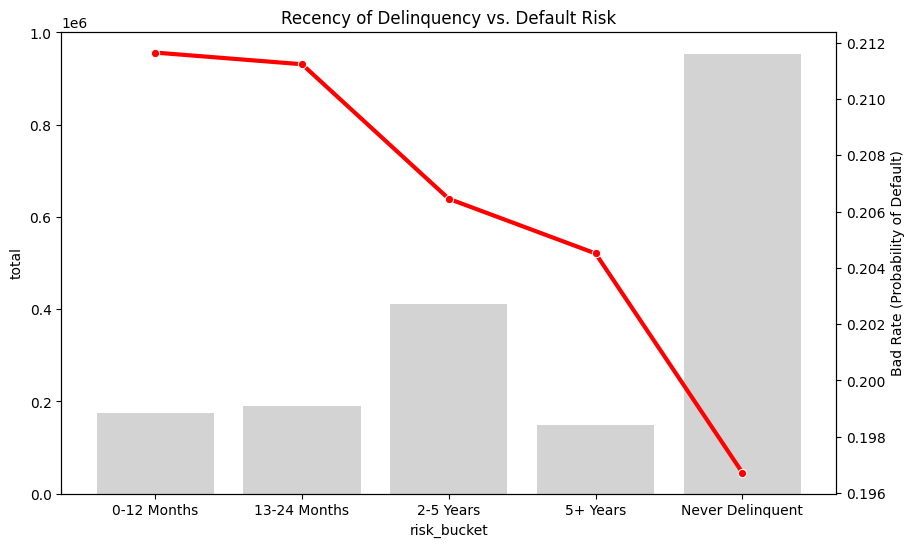

In [10]:
def analyze_delinq_risk(df: pd.DataFrame) -> None:
    """
    Analyzes the relationship between Recency of Delinquency and Default Risk.
    
    This function handles the 'NaN' values in 'mths_since_last_delinq' by 
    treating them as a distinct category ('Never Delinquent') to compare 
    their risk against borrowers with recent delinquencies. It buckets the 
    delinquency recency into categories (0-12 Months, 13-24 Months, 2-5 Years, 
    5+ Years, Never Delinquent) and plots the bad rate (default probability) 
    against these buckets, along with volume counts.

    Args:
        df (pd.DataFrame): Dataframe containing 'mths_since_last_delinq' (numeric, 
            months since last delinquency, NaN for never delinquent) and 'target' 
            (binary, 1 for default, 0 otherwise).

    Returns:
        None: Displays a dual-axis plot with volume bars (left axis) and bad rate 
        line (right axis).

    Raises:
        KeyError: If 'mths_since_last_delinq' or 'target' columns are missing.
    """
    temp_df = df[['mths_since_last_delinq', 'target']].copy()
    
    # Fill NaN with a placeholder string for visualization
    temp_df['delinq_bucket'] = temp_df['mths_since_last_delinq'].fillna('Never')
    
    # Bucket the numeric months for readability
    # 0-12 months (High Risk), 13-24, etc.
    def bucket_months(val):
        if val == 'Never':
            return 'Never Delinquent'
        if val <= 12:
            return '0-12 Months'
        if val <= 24:
            return '13-24 Months'
        if val <= 60:
            return '2-5 Years'
        return '5+ Years'

    temp_df['risk_bucket'] = temp_df['delinq_bucket'].apply(bucket_months)
    
    # Order the buckets logicially
    order = ['0-12 Months', '13-24 Months', '2-5 Years', '5+ Years', 'Never Delinquent']
    
    # Aggregate
    group = temp_df.groupby('risk_bucket').agg(
        total=('target', 'count'),
        bad=('target', 'sum')
    ).reindex(order)
    
    group['bad_rate'] = group['bad'] / group['total']
    
    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    sns.barplot(x=group.index, y='total', data=group, color='lightgrey', ax=ax1)
    ax2 = ax1.twinx()
    sns.lineplot(x=group.index, y='bad_rate', data=group, marker='o', color='red', lw=3, ax=ax2)
    
    ax1.set_title('Recency of Delinquency vs. Default Risk')
    ax2.set_ylabel('Bad Rate (Probability of Default)')
    plt.show()

analyze_delinq_risk(df)

#### 3. Credit Age Calculation
Raw dates (earliest_cr_line like "Aug-2003") are useless for models. We need "Years of History."

- Formula: Reference Date - Earliest Credit Line

- Reference Date: In a historical dataset, we use the Issue Date of the loan, not "Today." If we use "Today," a loan from 2007 will look like it has 17 extra years of history than it actually did at the time.

In [11]:
# Quick check of the date format

print(df['earliest_cr_line'].head())

0    Jan-1985
1    Apr-1999
2    Nov-2001
3    Feb-1996
4    Jan-1996
Name: earliest_cr_line, dtype: object


#### 4. Utilization (The "Maxed Out" Factor)
revol_util is the ratio of Balance / Credit Limit.

- High utilization (>80%) usually signals financial stress.

- Data Quirk: Sometimes this is loaded as a string ("50%") and needs stripping.

In [12]:
# Quick check of the format
print(df['revol_util'].head())

0    0.837
1    0.094
2    0.985
3    0.210
4    0.539
Name: revol_util, dtype: float64


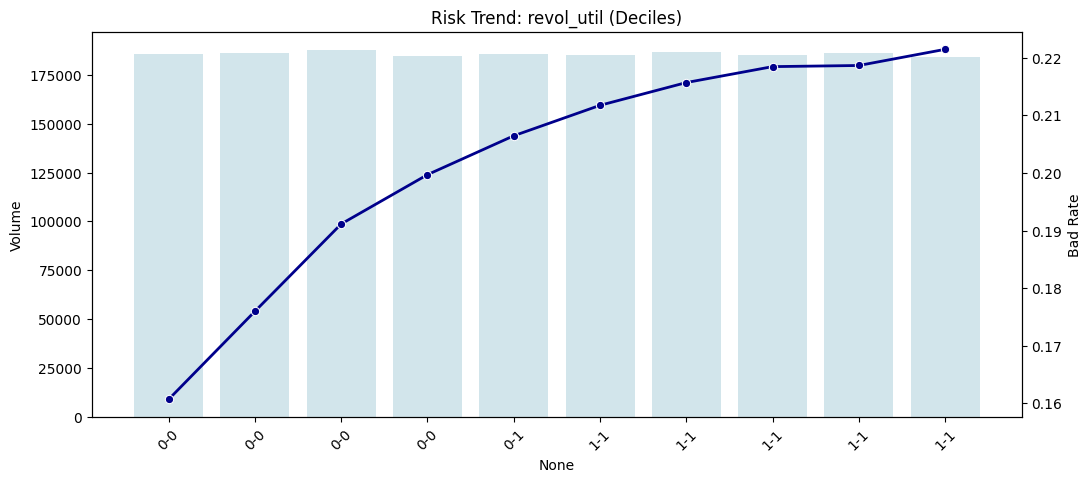

In [13]:
# Visualize Utilization Risk (Deciles)
# Re-using the generic continuous analyzer we built in Batch 2
# (If you haven't defined it in this notebook, copy the function 'analyze_continuous_risk' here)
# analyze_continuous_risk(df, 'revol_util')

def analyze_continuous_risk(df: pd.DataFrame, feature: str, bins: int = 10):
    """
    Discretizes a continuous variable into equal-sized buckets (quantiles)
    and plots the Bad Rate for each bucket to reveal non-linear trends.

    Args:
        df (pd.DataFrame): Input dataframe containing the feature and target columns.
        feature (str): Name of the continuous feature to analyze.
        bins (int, optional): Number of bins to create. Defaults to 10.

    Returns:
        None

    Raises:
        ValueError: If binning fails due to excessive duplicates and fallback also fails.
    """
    # Create a temporary copy
    temp_df = df[[feature, 'target']].copy()
    
    # Handle outliers for visualization: clip at 99th percentile
    # This prevents one billionaire from stretching the x-axis too far
    upper_limit = temp_df[feature].quantile(0.99)
    temp_df = temp_df[temp_df[feature] <= upper_limit]
    
    # Create quantiles (e.g., Deciles)
    try:
        temp_df['bucket'] = pd.qcut(temp_df[feature], q=bins, duplicates='drop')
    except ValueError:
        # Fallback if too many duplicate values (e.g. lots of 0s)
        temp_df['bucket'] = pd.cut(temp_df[feature], bins=bins)
        
    # Group and Calculate Bad Rate
    group = temp_df.groupby('bucket', observed=False).agg(
        min_value=(feature, 'min'),
        max_value=(feature, 'max'),
        total=('target', 'count'),
        bad=('target', 'sum')
    ).reset_index()
    
    group['bad_rate'] = group['bad'] / group['total']
    
    # Plot
    plt.figure(figsize=(12, 5))
    ax1 = sns.barplot(x=group.index, y='total', data=group, color='lightblue', alpha=0.6)
    ax2 = ax1.twinx()
    sns.lineplot(x=group.index, y='bad_rate', data=group, marker='o', color='darkblue', lw=2, ax=ax2)
    
    # Labeling
    ax1.set_xticks(range(len(group)))
    ax1.set_xticklabels([f"{row['min_value']:.0f}-{row['max_value']:.0f}" for _, row in group.iterrows()], rotation=45)
    ax1.set_ylabel('Volume')
    ax2.set_ylabel('Bad Rate')
    plt.title(f'Risk Trend: {feature} (Deciles)')
    plt.show()

# Run the analysis
analyze_continuous_risk(df, 'revol_util')


#### 5. Governance & Cleaning Function
The robust cleaning function for Batch 3. This function handles data type conversions, missing value imputation, and feature engineering for character features. It includes optimizations to avoid pandas UserWarnings by specifying date formats explicitly.

In [19]:
def clean_character_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Applies governance transformations to Credit History ('Character') features.

    Operations:
    1. mths_since_last_delinq: 
       - Imputes NaNs (Missing) with 999. This creates a distinct numeric cluster 
         far away from 0-12, allowing trees/regressions to handle it safely.
    2. revol_util:
       - Cleans '%' signs if present.
       - Fills missing values with the median (conservative approach).
    3. earliest_cr_line:
       - Converts to datetime.
       - Calculates 'credit_hist_years' = (issue_d - earliest_cr_line).
       - Handles potential data errors where credit line > issue date.

    Args:
        df_in (pd.DataFrame): Dataframe containing character columns + 'issue_d'.

    Returns:
        pd.DataFrame: A dataframe with new engineering history features.

    Raises:
        ValueError: If required columns are missing or date parsing fails due to invalid formats.
    """
    df_out = df_in.copy()
    
    # Validate required columns
    required_cols = ['issue_d', 'earliest_cr_line', 'mths_since_last_delinq', 'revol_util']
    missing_cols = [col for col in required_cols if col not in df_out.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # --- 1. Clean Delinquency Recency ---
    # Missing means "Never". We use a large number (999) to represent this.
    # This preserves the ordinality: 0 (bad) < 12 (better) < 999 (best)
    df_out['mths_since_last_delinq_clean'] = df_out['mths_since_last_delinq'].fillna(999)
    
    # --- 2. Clean Revolving Utilization ---
    # Handle string formatting if it exists
    if df_out['revol_util'].dtype == 'O':
         df_out['revol_util'] = df_out['revol_util'].str.strip('%').astype(float)
    
    # Fill NaN util with median (standard imputation)
    med_util = df_out['revol_util'].median()
    df_out['revol_util_clean'] = df_out['revol_util'].fillna(med_util)
    
    # --- 3. Engineer Credit History Length ---
    # Ensure date formats
    df_out['issue_d_dt'] = pd.to_datetime(df_out['issue_d'], format='%b-%Y')
    df_out['earliest_cr_dt'] = pd.to_datetime(df_out['earliest_cr_line'], format='%b-%Y')
    
    # Calculate months difference
    diff = df_out['issue_d_dt'] - df_out['earliest_cr_dt']
    months_diff = diff.dt.total_seconds() / (30 * 24 * 3600)
    df_out['credit_hist_years'] = months_diff / 12
    
    # Cap negative history (data errors where earliest_line > issue_date) at 0
    df_out['credit_hist_years'] = df_out['credit_hist_years'].clip(lower=0)
    
    return df_out

# Apply Cleaning
df_clean_char = clean_character_features(df)

print("Batch 3 Cleaning Complete.")
display(df_clean_char[['mths_since_last_delinq_clean', 'credit_hist_years', 'revol_util_clean']].head())

Batch 3 Cleaning Complete.


,mths_since_last_delinq_clean,credit_hist_years,revol_util_clean
0,999.0,27.305556,0.837
1,999.0,12.852778,0.094
2,999.0,10.227778,0.985
3,35.0,16.061111,0.210
4,38.0,16.147222,0.539


In [20]:
df_clean_char.to_pickle('../../data/interim/loans_batch3.pkl')
print("Base modeling data saved.")

Base modeling data saved.
